# JAXTrace Tutorial: Memory-Optimized Particle Tracking

This notebook demonstrates how to use JAXTrace for efficient particle tracking in computational fluid dynamics applications.

## Table of Contents
1. [Installation and Setup](#installation)
2. [Loading VTK Data](#loading-data)
3. [Basic Particle Tracking](#basic-tracking)
4. [Advanced Configuration](#advanced-config)
5. [Visualization](#visualization)
6. [Memory Optimization](#memory-optimization)
7. [Performance Comparison](#performance)


## 1. Installation and Setup {#installation}

First, let's import JAXTrace and check the system configuration.

In [1]:
# Fixed import section for the first cell:
import jaxtrace
from jaxtrace import (
    VTKReader, ParticleTracker, ParticleVisualizer, VTKExporter, DensityCalculator
)
from jaxtrace.utils import (
    get_memory_config, get_system_info, create_custom_particle_distribution,
    estimate_computational_requirements, create_progress_callback,
    save_simulation_config, load_simulation_config, benchmark_interpolation_methods
)

import numpy as np
import matplotlib.pyplot as plt

print(f"JAXTrace version: {jaxtrace.__version__}")
print(f"JAX available: {jaxtrace.JAX_AVAILABLE}")

JAXTrace initialized with JAX 0.6.2 on gpu
JAXTrace version: 0.1.0
JAX available: True


In [2]:
# Check system information
system_info = get_system_info()
print("System Information:")
for key, value in system_info.items():
    print(f"  {key}: {value}")

System Information:
  cpu_count: 20
  cpu_count_logical: 20
  memory_total_gb: 31.03771209716797
  memory_available_gb: 20.027938842773438
  memory_percent_used: 35.5
  jax_available: True
  gpu_memory_used_gb: 0.26177978515625
  gpu_memory_total_gb: 4.0
  gpu_memory_percent_used: 6.54449462890625
  gpu_available: True
  jax_devices: ['cuda:0']
  jax_default_backend: gpu


## 2. Loading VTK Data {#loading-data}

JAXTrace uses a memory-optimized VTK reader that can handle large datasets efficiently.

In [3]:
# Define VTK file pattern
# Replace this with your actual VTK file pattern
vtk_pattern = "/home/arhashemi/Workspace/welding/Cases/003_caseCoarse.gid/post/0eule/*_caseCoarse_*.pvtu"  # or "*.vtu", "simulation_*.vtk", etc.

# Alternative: Create example data if no VTK files available
# This section shows how to create synthetic data for testing
create_example_data = False  # Set to False if you have real VTK files

if create_example_data:
    print("Creating example synthetic data...")
    print("(In real applications, you would use actual VTK files)")
    
    # For this tutorial, we'll create synthetic data
    # In practice, you would replace this with your VTK file pattern
    vtk_pattern = "synthetic_data_*.vtk"  # This won't actually exist
else:
    # Initialize VTK reader with your data
    reader = VTKReader(
        file_pattern=vtk_pattern,
        max_time_steps=40,  # Limit to last 50 time steps for memory efficiency
        cache_size_limit=20   # Keep only 5 time steps in memory
    )
    
    # Get grid information
    grid_info = reader.get_grid_info()
    print(f"Grid Information:")
    print(f"  Number of grid points: {grid_info['n_points']}")
    print(f"  Number of time steps: {grid_info['n_timesteps']}")
    print(f"  Velocity field: {grid_info['velocity_field_name']}")
    print(f"  Domain bounds: {grid_info['bounds']}")
    
    # Validate VTK files
    validation = reader.validate_files()
    print(f"\nValidation: {validation['valid_files']}/{validation['total_files']} files valid")

Limited to last 40 time steps
VTKReader initialized with 40 time steps
Loaded grid with 6658 points
Auto-detected velocity field: 'Displacement'
Grid Information:
  Number of grid points: 6658
  Number of time steps: 40
  Velocity field: Displacement
  Domain bounds: (np.float32(-0.03), np.float32(0.07), np.float32(-0.02), np.float32(0.02), np.float32(-0.008), np.float32(0.0))
Validating VTK files...
Validation complete: 40/40 files valid

Validation: 40/40 files valid


## 3. Basic Particle Tracking {#basic-tracking}

Now let's set up a basic particle tracking simulation.

In [ ]:
# For demonstration, we'll create synthetic particle tracking
# In real applications, you would use the VTK reader from above

if create_example_data:
    # Create synthetic example for demonstration
    print("Running synthetic particle tracking example...")
    
    # Define simulation domain
    box_bounds = ((0.0, 10.0), (0.0, 5.0), (2.0, 8.0))  # (x_min, x_max), (y_min, y_max), (z_min, z_max)
    
    # Create initial particle distribution
    initial_positions = create_custom_particle_distribution(
        box_bounds=box_bounds,
        distribution_type='uniform',
        n_particles=1000,
        random_seed=42
    )
    
    # Simulate simple motion (in real case, this would be done by ParticleTracker)
    n_steps = 50
    dt = 0.1
    
    # Simple spiral motion for demonstration
    positions = initial_positions.copy()
    trajectory_data = [positions.copy()]
    
    for step in range(n_steps):
        # Simple velocity field: spiral motion
        center = np.array([5.0, 2.5, 5.0])
        relative_pos = positions - center
        
        # Circular motion in XY plane, upward drift in Z
        velocities = np.zeros_like(positions)
        velocities[:, 0] = -relative_pos[:, 1] * 0.2  # -y component
        velocities[:, 1] = relative_pos[:, 0] * 0.2   # x component  
        velocities[:, 2] = 0.1                        # upward drift
        
        # Add some noise
        velocities += np.random.normal(0, 0.02, velocities.shape)
        
        # Update positions
        positions += velocities * dt
        trajectory_data.append(positions.copy())
    
    # Convert to trajectory array
    trajectories = np.array(trajectory_data).transpose(1, 0, 2)  # (n_particles, n_steps+1, 3)
    final_positions = trajectories[:, -1, :]
    
    print(f"Synthetic tracking complete: {len(final_positions)} particles, {n_steps} steps")
    
else:
    # Real particle tracking with VTK data
    print("Setting up real particle tracking...")
    
    # Initialize particle tracker
    tracker = ParticleTracker(
        vtk_reader=reader,
        max_gpu_memory_gb=4.0,
        k_neighbors=4,
        shape_function='linear',
        interpolation_method='finite_element'
    )
    
    print(f"Tracker initialized: {tracker}")
    
    n_steps = 700 # Number of time steps to advect
    dt = 0.1  # Time step size
    box_bounds = ((-0.025, -0.010), (-0.0198, 0.0198), (-0.008, 0.0))  # Adjust as needed
    resolution = (10, 50, 20)  # Adjust density as needed
    # Create initial particle grid
    initial_positions = tracker.create_particle_grid(
        resolution=resolution,  # 8000 particles
        #bounds_padding=0.1,
        box_bounds=box_bounds
    )
    
    # Set up progress tracking
    progress_callback = create_progress_callback(
        update_frequency=50,
        show_memory=True,
        show_time=True
    )
    
    # Run particle tracking
    final_positions = tracker.track_particles(
        initial_positions=initial_positions,
        dt=dt,
        n_steps=n_steps,
        integration_method='rk4',
        progress_callback=progress_callback,
        save_trajectories=False  # Set to True if you want full trajectories
    )
    
    print(f"Particle tracking complete: {len(final_positions)} particles")

Setting up real particle tracking...
ParticleTracker initialized with finite_element interpolation
Grid: 6658 points, 40 timesteps
Tracker initialized: ParticleTracker(interpolation='finite_element', shape_function='linear', k_neighbors=8, grid_points=6658)
Using custom box bounds: x=[-0.03, -0.01], y=[-0.02, 0.02], z=[-0.01, 0.00]
Created 10000 particles in 10×50×20 grid
Estimated batch size for rk4: 5000 particles
Tracking 10000 particles for 700 steps
Integration method: rk4, batch size: 5000
Time step stride: 1
Velocity cache cleared
Velocity cache cleared
Velocity cache cleared
Step 100/700 (time_idx: 39)
Step 100 | elapsed: 387.9s | RAM: 1.02 GB | GPU: 0.39/4.00 GB | pos_mean: [0.04, -0.00, -0.00]
Step 200/700 (time_idx: 39)
Step 200 | elapsed: 796.0s | RAM: 1.02 GB | GPU: 0.39/4.00 GB | pos_mean: [0.08, -0.00, -0.00]
Step 300/700 (time_idx: 39)
Step 300 | elapsed: 1203.8s | RAM: 1.02 GB | GPU: 0.39/4.00 GB | pos_mean: [0.13, -0.00, -0.00]
Step 400/700 (time_idx: 39)
Step 400 | e

## 4. Advanced Configuration {#advanced-config}

JAXTrace provides several preset configurations optimized for different memory and accuracy requirements.

In [5]:
# Explore available memory configurations
configs = ['low_memory', 'medium_memory', 'high_memory', 'high_accuracy']

print("Available Configuration Presets:")
for config_name in configs:
    config = get_memory_config(config_name)
    print(f"\n{config_name.upper()}:")
    for key, value in config.items():
        print(f"  {key}: {value}")

Available Configuration Presets:

LOW_MEMORY:
  max_time_steps: 20
  particle_resolution: (20, 20, 20)
  integration_method: euler
  spatial_subsample: 2
  temporal_subsample: 2
  max_gpu_memory_gb: 4.0
  k_neighbors: 4
  shape_function: linear
  interpolation_method: nearest_neighbor
  cache_size_limit: 3

MEDIUM_MEMORY:
  max_time_steps: 40
  particle_resolution: (30, 30, 30)
  integration_method: rk2
  spatial_subsample: 1
  temporal_subsample: 1
  max_gpu_memory_gb: 8.0
  k_neighbors: 6
  shape_function: linear
  interpolation_method: finite_element
  cache_size_limit: 5

HIGH_MEMORY:
  max_time_steps: 100
  particle_resolution: (50, 50, 50)
  integration_method: rk4
  spatial_subsample: 1
  temporal_subsample: 1
  max_gpu_memory_gb: 16.0
  k_neighbors: 8
  shape_function: quadratic
  interpolation_method: finite_element
  cache_size_limit: 10

HIGH_ACCURACY:
  max_time_steps: 60
  particle_resolution: (40, 40, 40)
  integration_method: rk4
  spatial_subsample: 1
  temporal_subsamp

In [6]:
# Estimate computational requirements for different configurations
print("Computational Requirements Estimation:")

for config_name in ['medium_memory', 'high_accuracy']:
    config = get_memory_config(config_name)
    
    # Calculate number of particles
    n_particles = np.prod(config['particle_resolution'])
    n_timesteps = config['max_time_steps']
    
    requirements = estimate_computational_requirements(
        n_particles=n_particles,
        n_timesteps=n_timesteps,
        integration_method=config['integration_method'],
        interpolation_method=config['interpolation_method'],
        k_neighbors=config['k_neighbors']
    )
    
    print(f"\n{config_name.upper()}:")
    print(f"  Particles: {requirements['n_particles']:,}")
    print(f"  Estimated memory: {requirements['estimated_memory_gb']:.2f} GB")
    print(f"  Estimated runtime: {requirements['estimated_runtime_hours']:.2f} hours")
    if requirements['recommendations']:
        print(f"  Recommendations: {'; '.join(requirements['recommendations'])}")

Computational Requirements Estimation:

MEDIUM_MEMORY:
  Particles: 27,000
  Estimated memory: 0.50 GB
  Estimated runtime: 0.00 hours

HIGH_ACCURACY:
  Particles: 64,000
  Estimated memory: 0.51 GB
  Estimated runtime: 0.01 hours
  Recommendations: Consider RK2 or Euler for better performance with many particles


## 5. Visualization {#visualization}

JAXTrace provides comprehensive visualization capabilities for analyzing particle tracking results.

In [7]:
# Initialize visualizer
if create_example_data:
    # Use synthetic data
    visualizer = ParticleVisualizer(
        final_positions=final_positions,
        initial_positions=initial_positions,
        trajectories=trajectories
    )
else:
    # Use real tracking results
    visualizer = ParticleVisualizer(
        final_positions=final_positions,
        initial_positions=initial_positions
    )

print(f"Visualizer initialized: {visualizer}")
print("Visualizer info:")
viz_info = visualizer.get_visualization_info()
for key, value in viz_info.items():
    print(f"  {key}: {value}")

ParticleVisualizer initialized with 10000 particles
Visualizer initialized: ParticleVisualizer(n_particles=10000, has_initial=True)
Visualizer info:
  n_particles: 10000
  has_initial_positions: True
  has_trajectories: False
  final_position_bounds: {'x': (-0.0009745350107550621, 0.3534833490848541), 'y': (-0.022185014560818672, 0.020130185410380363), 'z': (-0.008215414360165596, 0.0026054978370666504)}
  jax_available: True
  plotly_available: True
  initial_position_bounds: {'x': (-0.02500000037252903, -0.009999999776482582), 'y': (-0.01979999989271164, 0.01979999989271164), 'z': (-0.00800000037997961, 0.0)}


Export to VTK

In [ ]:
try:
    saved_files = visualizer.export_to_vtk(
        output_directory="simulation_results",
        base_filename="cfd_tracking",
        include_density=True,
        density_params={
            'plane': 'xy',
            'position': 0.0,
            'slab_thickness': 1.0,
            'method': 'jax_kde' if jaxtrace.JAX_AVAILABLE else 'scipy_kde',
            'grid_resolution': 100
        },
        time_value=100.0
    )
    print("VTK export completed successfully!")
    for key, path in saved_files.items():
        print(f"  {key}: {path}")
        
except Exception as e:
    print(f"VTK export failed: {e}")
    print("This is normal if no particle data has been created yet.")

VTKWriter initialized. Output directory: simulation_results
Calculated density field for export
Saved particle positions to simulation_results/cfd_tracking_final.vtp (10000 particles)
Saved particle positions to simulation_results/cfd_tracking_initial.vtp (10000 particles)
Saved density field to simulation_results/cfd_tracking_density.vti (200x200 grid)
Saved 3 files to simulation_results
Created ParaView state file: simulation_results/paraview_state.pvsm

VTK Export Summary:
Output directory: simulation_results
Files created:


NameError: name 'os' is not defined

Creating 3D position plot...


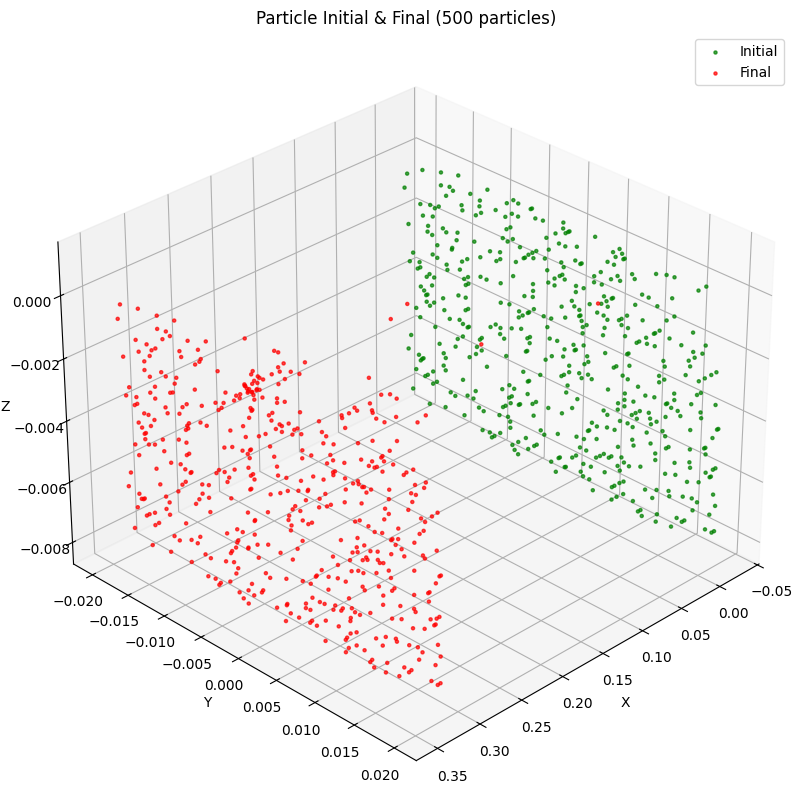

In [ ]:
# 3D scatter plot of particle positions
try:
    print("Creating 3D position plot...")
    visualizer.plot_3d_positions(
        show_initial=True,
        show_final=True,
        show_trajectories=True,  # Only works if trajectories are available
        n_show=500,  # Show subset for performance
        cam_view=(45, 30, 0),  # Azimuth, elevation, roll
        figsize=(12, 10)
    )
except Exception as e:
    print(f"3D plot failed: {e}")
    print("Please ensure particle tracking has been completed first.")

Creating cross-section plots...


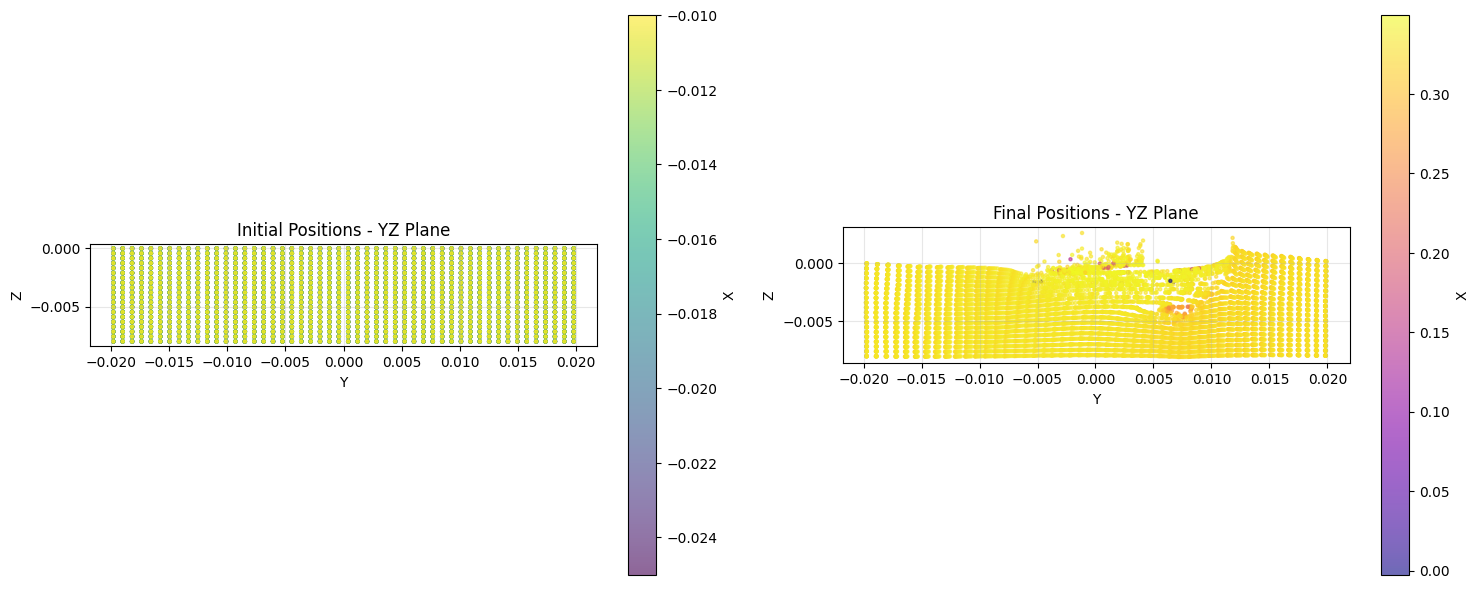

In [12]:
# Cross-section analysis
print("Creating cross-section plots...")
visualizer.plot_cross_sections(
    plane='yz',
    position=0.2,  # Z = 5.0
    slab_thickness=1.0,
    show_initial=True,
    show_final=True,
    figsize=(15, 6)
)

Creating displacement analysis...


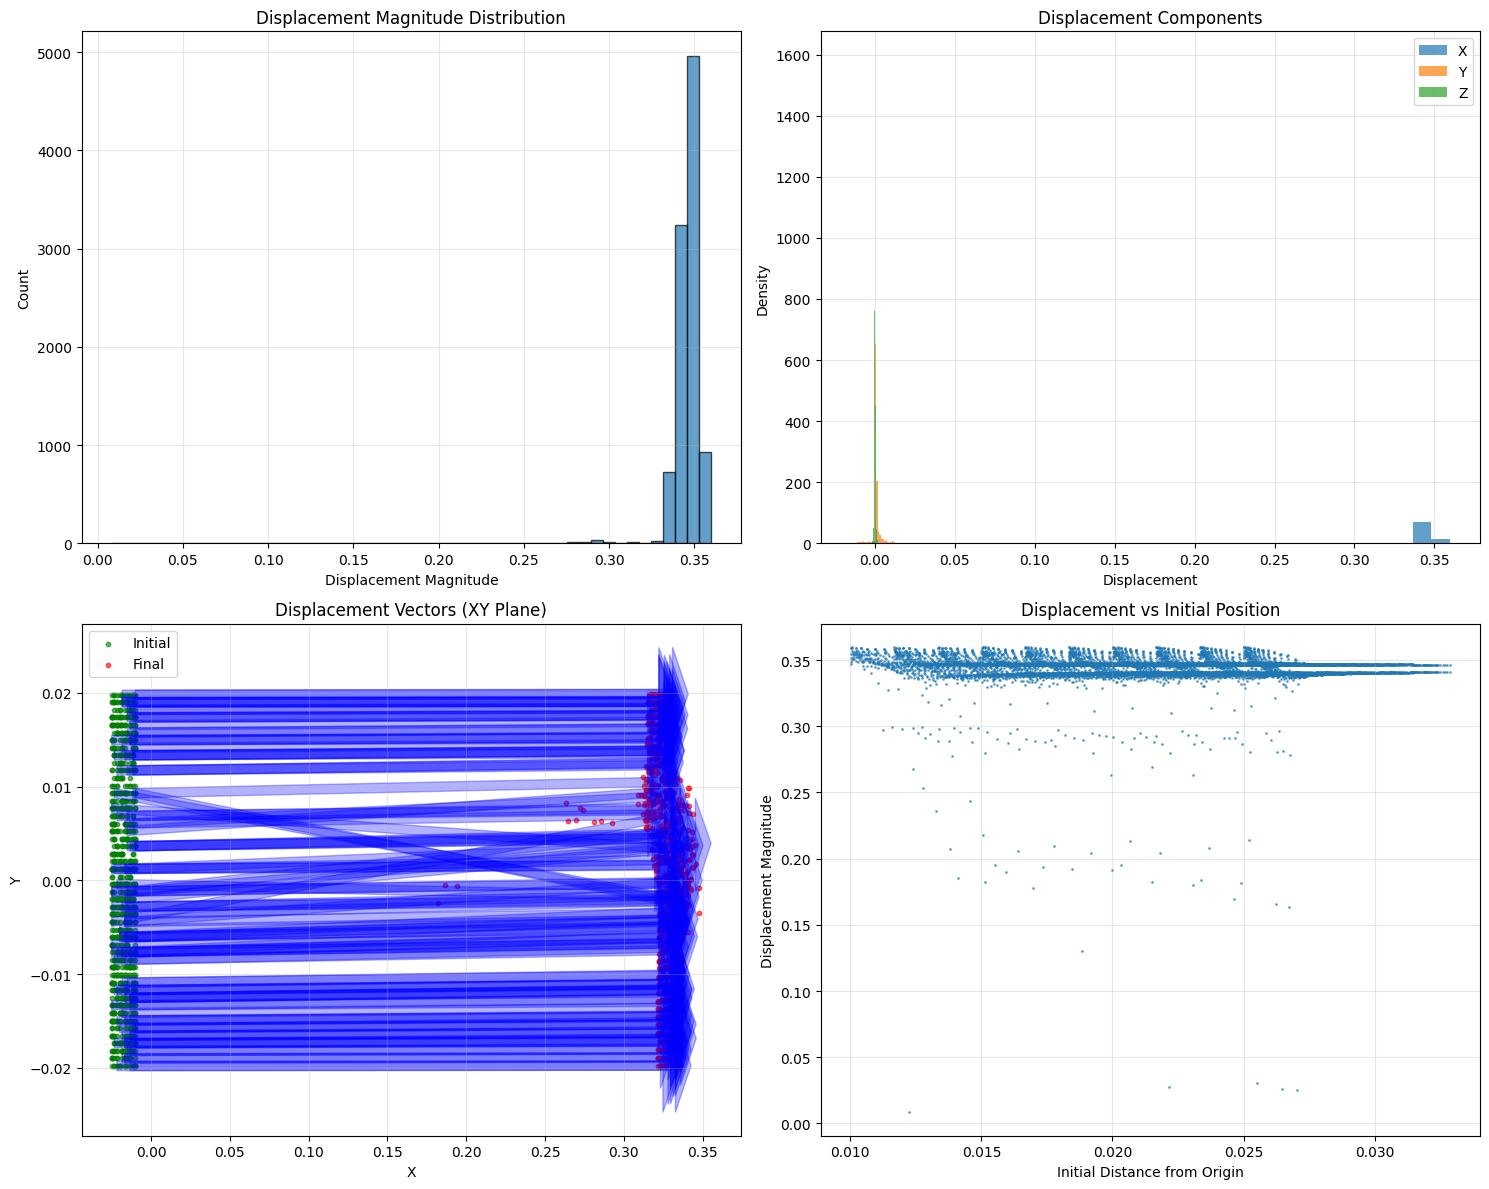

Displacement Statistics:
  Mean displacement: 0.3442
  Std displacement: 0.0129
  Max displacement: 0.3598
  Min displacement: 0.0083


In [ ]:
# Displacement analysis (if initial positions available)
if visualizer.initial_positions is not None:
    print("Creating displacement analysis...")
    visualizer.plot_displacement_analysis(figsize=(15, 12))
else:
    print("Displacement analysis requires initial positions")

### Advanced Density Visualization

JAXTrace supports advanced density estimation methods including JAX-accelerated KDE and SPH.

Creating density plots...


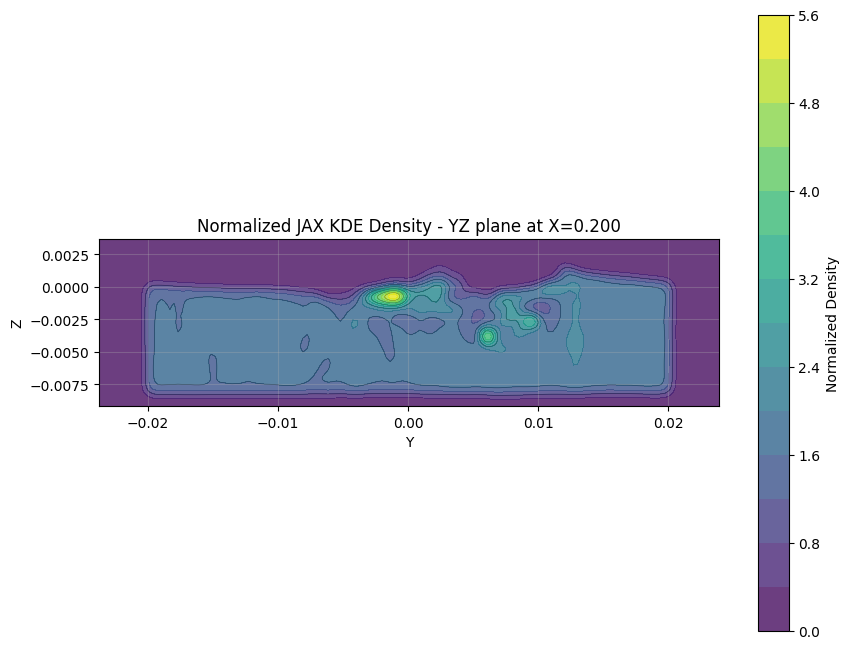

In [15]:
# Density estimation with different methods
print("Creating density plots...")

# JAX KDE density plot
if jaxtrace.JAX_AVAILABLE:
    visualizer.plot_density(
        positions='final',
        plane='yz',
        position=0.2,
        slab_thickness=0.5,
        method='jax_kde',
        grid_resolution=150,
        bandwidth=0.0005,
        levels=15,
        cmap='viridis'
    )
else:
    print("JAX not available, using fallback density method")
    visualizer.plot_density(
        positions='final',
        plane='yz', 
        position=0.2,
        slab_thickness=0.25,
        method='seaborn',
        grid_resolution=100,
        levels=15,
        cmap='viridis'
    )

Creating combined analysis plot...


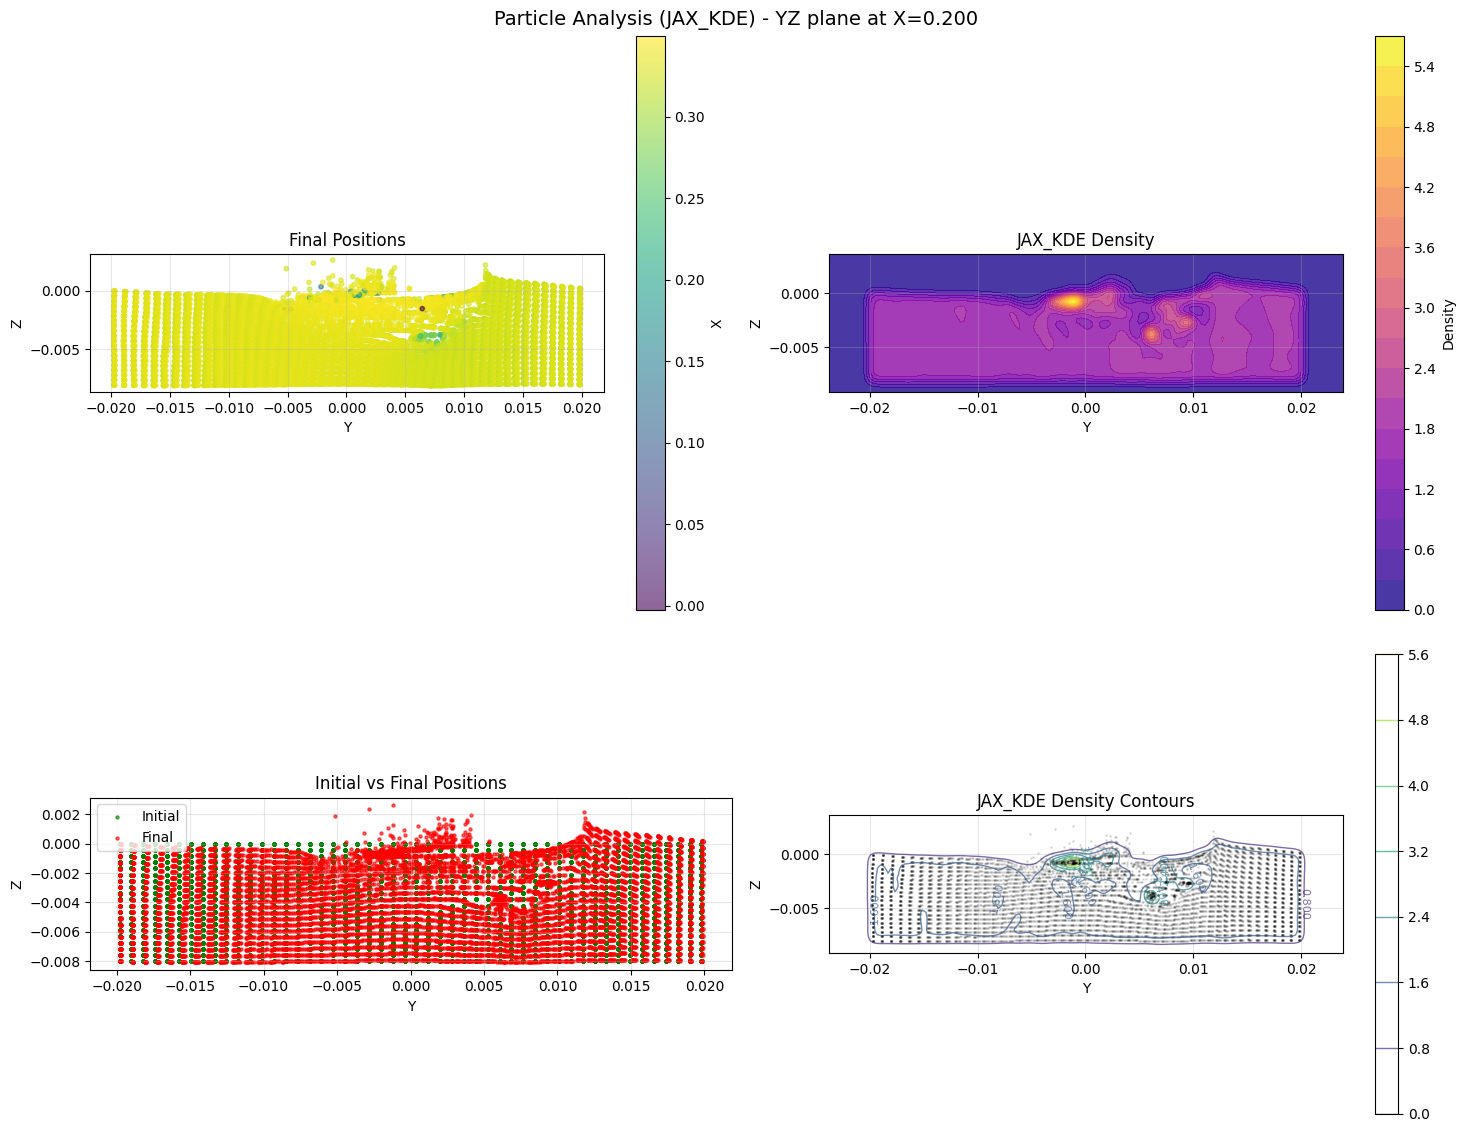

In [16]:
# Combined analysis plot
print("Creating combined analysis plot...")
visualizer.plot_combined_analysis(
    plane='yz',
    position=0.2,
    slab_thickness=0.5,
    method='jax_kde' if jaxtrace.JAX_AVAILABLE else 'seaborn',
    grid_resolution=150,
    bandwidth=0.0005,
    figsize=(15, 12)
)

In [24]:
# Combined analysis plot
print("Creating combined analysis plot...")
visualizer.plot_combined_analysis(
    plane='yz',
    position=0.2,
    slab_thickness=0.5,
    method='sph' if jaxtrace.JAX_AVAILABLE else 'seaborn',
    grid_resolution=150,
    smoothing_length = None,#0.001,
    kernel_type = 'gaussian', #'cubic_spline', 'gaussian', 'wendland'
    adaptive = True,
    n_neighbors = 2,
    figsize=(15, 12)
)

Creating combined analysis plot...


2025-07-14 19:43:50.583383: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.49GiB (rounded to 1600040704)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-07-14 19:43:50.583458: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] **************_____*****************************_________***************___________________________*
E0714 19:43:50.583473 3796454 pjrt_stream_executor_client.cc:2916] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1600040704 bytes. [tf-allocator-allocation-error='']


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1600040704 bytes.

In [23]:
# Interactive 3D visualization (if Plotly is available)
try:
    print("Creating interactive 3D plot...")
    visualizer.plot_interactive_3d(
        show_initial=True,
        show_final=True,
        show_trajectories=True,
        n_show=500
    )
except ImportError:
    print("Plotly not available. Install with: pip install plotly")

Creating interactive 3D plot...


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## 6. Memory Optimization {#memory-optimization}

JAXTrace provides several strategies for memory optimization when dealing with large datasets.

In [24]:
# Example: Memory-optimized tracking with subsampling
if not create_example_data:  # Only for real VTK data
    print("Demonstrating memory optimization techniques...")
    
    # Create a larger initial grid
    large_initial_positions = tracker.create_particle_grid(
        resolution=(40, 40, 40),  # 64,000 particles
        bounds_padding=0.1
    )
    
    print(f"Large particle set: {len(large_initial_positions)} particles")
    
    # Track with spatial and temporal subsampling
    optimized_final_positions = tracker.track_particles_with_subsampling(
        initial_positions=large_initial_positions,
        dt=0.01,
        n_steps=1000,
        spatial_subsample_factor=2,  # Use every 2nd particle
        temporal_subsample_factor=2,  # Use every 2nd time step
        integration_method='euler'
    )
    
    print(f"Optimized tracking: {len(optimized_final_positions)} particles")

else:
    print("Memory optimization examples require real VTK data")

Demonstrating memory optimization techniques...
Using grid bounds with padding: x=[-0.02, 0.06], y=[-0.02, 0.02], z=[-0.01, -0.00]
Created 64000 particles in 40×40×40 grid
Large particle set: 64000 particles
Spatial subsampling: 64000 -> 32000 particles
Temporal subsampling: dt=0.01->0.02, steps=1000->500
Estimated batch size for euler: 20000 particles
Tracking 32000 particles for 500 steps
Integration method: euler, batch size: 100
Time step stride: 2
Velocity cache cleared
Velocity cache cleared
Step 100/500 (time_idx: 39)
Step 200/500 (time_idx: 39)
Step 300/500 (time_idx: 39)
Step 400/500 (time_idx: 39)
Step 500/500 (time_idx: 39)
Optimized tracking: 32000 particles


In [25]:
# Demonstrate automatic parameter optimization
from jaxtrace.utils import optimize_parameters_for_system, validate_simulation_parameters

# Start with a high-memory configuration
base_config = get_memory_config('high_memory')
print("Base configuration:")
for key, value in base_config.items():
    print(f"  {key}: {value}")

# Validate parameters
is_valid, issues = validate_simulation_parameters(base_config)
print(f"\nConfiguration valid: {is_valid}")
if issues:
    for issue in issues:
        print(f"  - {issue}")

# Optimize for current system
optimized_config = optimize_parameters_for_system(
    base_config=base_config,
    target_memory_gb=4.0,  # Target 4GB memory usage
    target_runtime_hours=1.0  # Target 1 hour runtime
)

print("\nOptimized configuration:")
for key, value in optimized_config.items():
    if key in base_config and base_config[key] != value:
        print(f"  {key}: {base_config[key]} → {value} (changed)")
    else:
        print(f"  {key}: {value}")

Base configuration:
  max_time_steps: 100
  particle_resolution: (50, 50, 50)
  integration_method: rk4
  spatial_subsample: 1
  temporal_subsample: 1
  max_gpu_memory_gb: 16.0
  k_neighbors: 8
  shape_function: quadratic
  interpolation_method: finite_element
  cache_size_limit: 10

Configuration valid: True
Parameter optimization complete

Optimized configuration:
  max_time_steps: 100
  particle_resolution: (50, 50, 50)
  integration_method: rk4
  spatial_subsample: 1
  temporal_subsample: 1
  max_gpu_memory_gb: 16.0
  k_neighbors: 8
  shape_function: quadratic
  interpolation_method: finite_element
  cache_size_limit: 10


## 7. Performance Comparison {#performance}

Compare different integration and interpolation methods to find the best performance for your use case.

In [28]:
# Benchmark interpolation methods
if jaxtrace.JAX_AVAILABLE:
    from jaxtrace.utils import benchmark_interpolation_methods
    
    print("Benchmarking interpolation methods...")
    benchmark_results = benchmark_interpolation_methods(
        n_particles=5000,
        n_evaluations=1000,
        methods=['nearest_neighbor', 'finite_element']
    )
    
    print("\nBenchmark Results:")
    for method, results in benchmark_results.items():
        print(f"\n{method.upper()}:")
        print(f"  Time per evaluation: {results['time_per_evaluation_ms']:.3f} ms")
        print(f"  Evaluations per second: {results['evaluations_per_second']:.0f}")
        print(f"  Total time: {results['total_time_seconds']:.3f} s")
else:
    print("JAX not available for benchmarking")

Benchmarking interpolation methods...
Benchmarking nearest_neighbor...
  nearest_neighbor: 0.026 ms/eval, 37873 eval/s
Benchmarking finite_element...
  finite_element: 0.327 ms/eval, 3054 eval/s

Benchmark Results:

NEAREST_NEIGHBOR:
  Time per evaluation: 0.026 ms
  Evaluations per second: 37873
  Total time: 0.026 s

FINITE_ELEMENT:
  Time per evaluation: 0.327 ms
  Evaluations per second: 3054
  Total time: 0.327 s


Comparing density estimation methods...
ParticleVisualizer initialized with 10000 particles


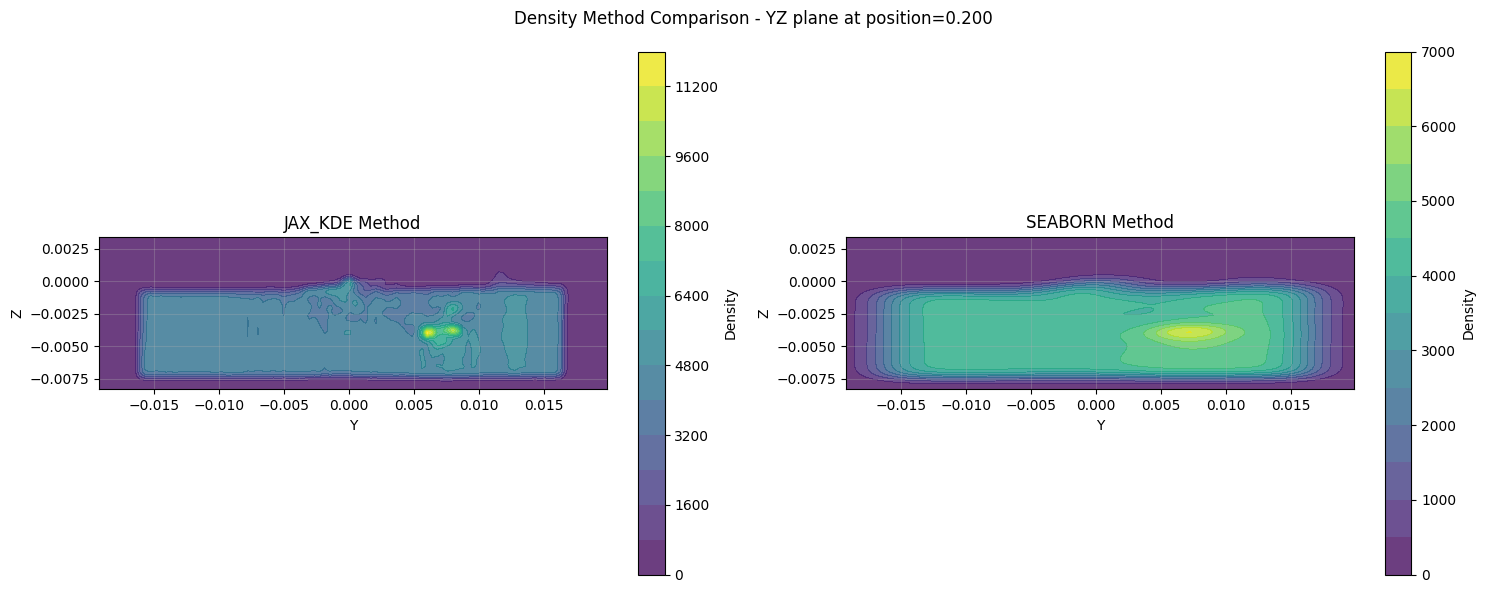

In [ ]:
# Compare density estimation methods
try:
    if jaxtrace.JAX_AVAILABLE:
        print("Comparing density estimation methods...")
        visualizer.compare_density_methods(
            plane='xy',
            position=0.2,
            slab_thickness=0.5,
            methods=['jax_kde', 'sph'],  # Removed 'seaborn' - use 'scipy_kde'
            figsize=(15, 6),
            normalize=True
        )
    else:
        print("JAX not available for density method comparison")
        print("Using scipy fallback method...")
        visualizer.plot_density(
            method='scipy_kde',
            plane='xy',
            position=0.2,
            normalize=True
        )
except Exception as e:
    print(f"Density comparison failed: {e}")

## 8. Saving and Loading Results

Save your simulation configuration and results for reproducibility.

In [33]:
# Save simulation configuration
from jaxtrace.utils import save_simulation_config, load_simulation_config

# Use the optimized configuration from earlier
config_to_save = optimized_config
config_to_save['simulation_name'] = 'tutorial_example'
config_to_save['description'] = 'JAXTrace tutorial simulation with optimized parameters'

# Save configuration
save_simulation_config(config_to_save, 'tutorial_config.json')

# Load configuration (demonstration)
loaded_config = load_simulation_config('tutorial_config.json')
print("Loaded configuration:")
for key, value in loaded_config.items():
    print(f"  {key}: {value}")

Configuration saved to tutorial_config.json
Configuration loaded from tutorial_config.json
Loaded configuration:
  max_time_steps: 100
  particle_resolution: [50, 50, 50]
  integration_method: rk4
  spatial_subsample: 1
  temporal_subsample: 1
  max_gpu_memory_gb: 16.0
  k_neighbors: 8
  shape_function: quadratic
  interpolation_method: finite_element
  cache_size_limit: 10
  simulation_name: tutorial_example
  description: JAXTrace tutorial simulation with optimized parameters


In [ ]:
exporter = VTKExporter("output_directory")
saved_files = exporter.export_complete_simulation(
    positions=final_positions,
    base_filename="tutorial_results",
    initial_positions=initial_positions,
    calculate_density=True,
    density_method='jax_kde' if jaxtrace.JAX_AVAILABLE else 'scipy_kde'
)

In [34]:
# Save particle positions for later analysis
import os

# Create output directory
output_dir = 'tutorial_output'
os.makedirs(output_dir, exist_ok=True)

# Save positions as numpy arrays
np.save(os.path.join(output_dir, 'final_positions.npy'), final_positions)
if visualizer.initial_positions is not None:
    np.save(os.path.join(output_dir, 'initial_positions.npy'), visualizer.initial_positions)
if visualizer.trajectories is not None:
    np.save(os.path.join(output_dir, 'trajectories.npy'), visualizer.trajectories)

print(f"Results saved to {output_dir}/")
print(f"Files created:")
for file in os.listdir(output_dir):
    filepath = os.path.join(output_dir, file)
    size_mb = os.path.getsize(filepath) / 1024**2
    print(f"  {file}: {size_mb:.2f} MB")

Results saved to tutorial_output/
Files created:
  initial_positions.npy: 0.11 MB
  final_positions.npy: 0.11 MB


## 9. Advanced Usage Tips

Here are some advanced tips for getting the best performance from JAXTrace.

Creating custom particle distributions...
Created 1000 particles with 'uniform' distribution
Created 1000 particles with 'random' distribution
Created 1000 particles with 'gaussian' distribution
Created 1000 particles with 'stratified' distribution
Created 1000 particles with 'clustered' distribution


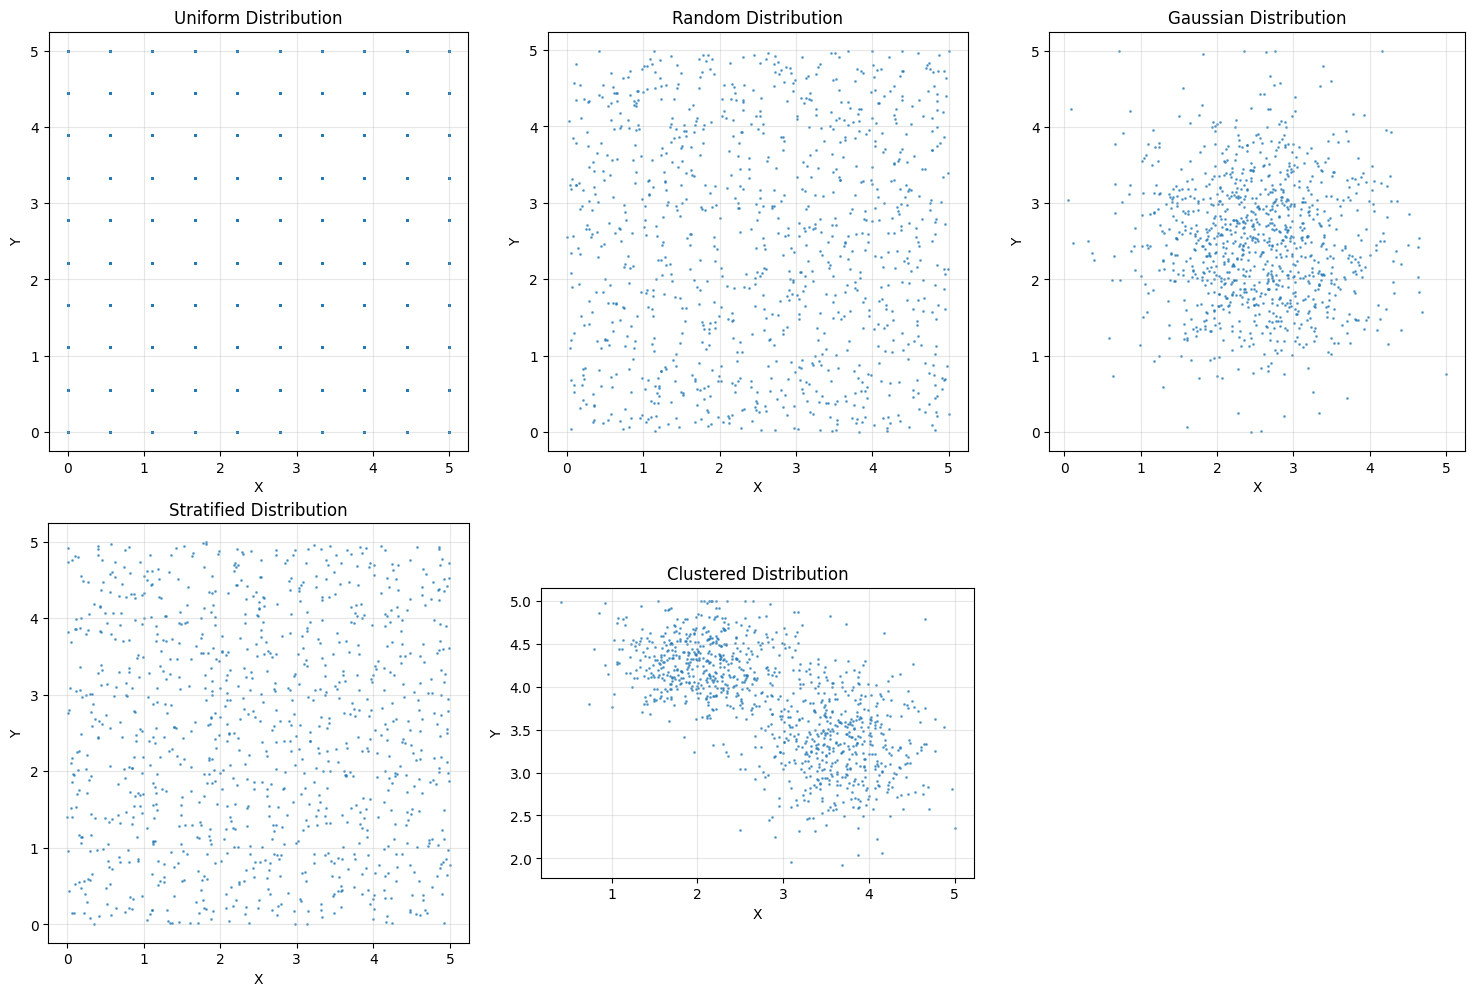

In [35]:
# Custom particle distributions for specific applications
print("Creating custom particle distributions...")

# Different distribution types
distributions = ['uniform', 'random', 'gaussian', 'stratified', 'clustered']
box_bounds = ((0, 5), (0, 5), (0, 5))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, dist_type in enumerate(distributions):
    positions = create_custom_particle_distribution(
        box_bounds=box_bounds,
        distribution_type=dist_type,
        n_particles=1000,
        random_seed=42
    )
    
    ax = axes[i]
    ax.scatter(positions[:, 0], positions[:, 1], alpha=0.6, s=1)
    ax.set_title(f'{dist_type.capitalize()} Distribution')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

# Remove empty subplot
axes[-1].remove()

plt.tight_layout()
plt.show()

In [36]:
# Memory monitoring during simulation
from jaxtrace.utils import monitor_memory_usage

@monitor_memory_usage
def example_memory_intensive_operation():
    """Example function to demonstrate memory monitoring."""
    # Create large array
    large_array = np.random.randn(1000000, 3)
    
    # Do some computation
    result = np.mean(large_array, axis=0)
    
    # Clean up
    del large_array
    
    return result

print("Demonstrating memory monitoring:")
result = example_memory_intensive_operation()
print(f"Result: {result}")

Demonstrating memory monitoring:
example_memory_intensive_operation: Memory usage: 1.35 -> 1.35 GB (Δ+0.00 GB)
Result: [-0.00042724 -0.00107098 -0.0002649 ]


## Summary

This tutorial covered:

1. **Setting up JAXTrace** with system information checks
2. **Loading VTK data** with memory-optimized readers
3. **Basic particle tracking** with different integration methods
4. **Advanced configuration** using preset configurations
5. **Comprehensive visualization** including 3D plots, cross-sections, and density estimation
6. **Memory optimization** strategies for large datasets
7. **Performance comparison** of different methods
8. **Saving and loading** results for reproducibility

### Key Features of JAXTrace:

- **Memory-optimized**: Handles large VTK datasets efficiently
- **GPU-accelerated**: Uses JAX for high-performance computing
- **Flexible**: Multiple integration and interpolation methods
- **Visual**: Comprehensive visualization capabilities
- **Configurable**: Easy-to-use preset configurations
- **Scalable**: Automatic parameter optimization

### Next Steps:

1. Replace the synthetic data with your actual VTK files
2. Experiment with different configuration presets
3. Use the memory optimization features for large simulations
4. Explore advanced visualization options
5. Benchmark different methods for your specific use case

For more information, see the JAXTrace documentation and examples.